## Import libraries

In [13]:
import skfuzzy as fuzz
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import seaborn as sns
import plotly.express as px
from numba import njit
from scipy.spatial.distance import cdist
from numpy import where, exp, eye, column_stack
from time import time

# bigger font
font = {'family' : 'helvetica','size'   : 18}
plt.rc('font', **font) 

## Simulate Double Gyre

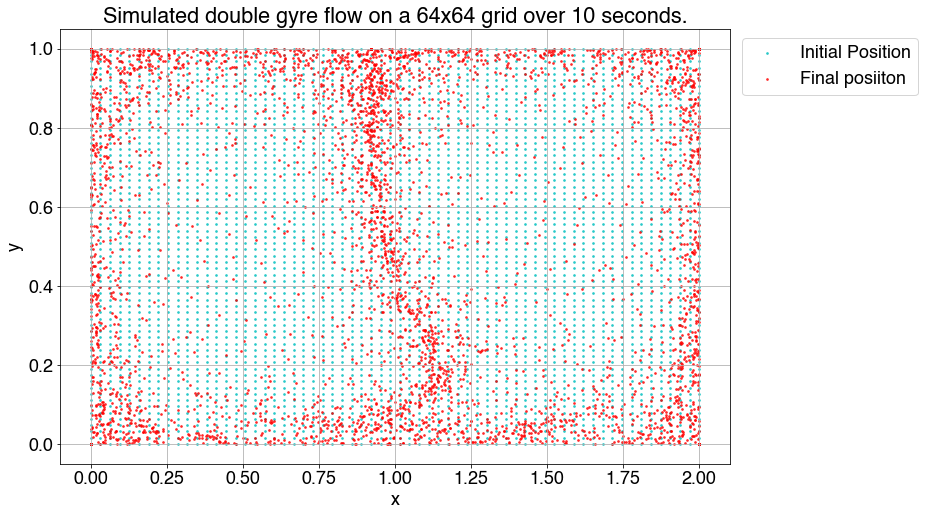

In [10]:
# constants
A = 0.25
epsilon = 0.25
w = np.pi*2 #/10

# horizontal comp.
def f(x,t):
    return epsilon*np.sin(w*t)*(x**2) + (1-2*epsilon*np.sin(w*t))*x

def u_gyre(x,y,t):
    return -np.pi*A*np.sin(np.pi*f(x,t))*np.cos(np.pi*y)

def v_gyre(x,y,t):
    return ((2*epsilon*np.sin(w*t)*x 
            + 1-2*epsilon*np.sin(w*t))*np.sin(np.pi*y)*np.pi*A*np.cos(np.pi*f(x,t)))

# function for random data init 

def rand_trace_double_gyre(Nx, Ny, final_t=20, no_t_step=201):
    
    x0 = np.linspace(0, 2, Nx)
    y0 = np.linspace(0, 1, Ny)
    
    x0, y0 =np.meshgrid(x0,y0)
    
    # time steps
    times, dt = np.linspace(0,final_t, no_t_step, retstep = True)

    # init arrays for point data
    x_pos = []
    y_pos = []

    # maybe add noise to this?

    # now reshape
    x = x0
    y = y0

    # save positions
    x_pos.append(x0)
    y_pos.append(y0)

    # loop through each time step
    for t in times:
        x1 = x + u_gyre(x,y,t)*dt
        y1 = y + v_gyre(x,y,t)*dt

        # save positions
        x_pos.append(x1)
        y_pos.append(y1)

        y = np.copy(y1)
        x = np.copy(x1)
        
    return x_pos, y_pos, dt

def rand_trace_double_gyre_old(M, final_t = 20, no_t_step = 201):

    # generate initial coords
    # draw in interval [0,1] to see it at work
    x0 = np.random.uniform(0,2,M)
    #x0 = (x0 - 0.5)*NX

    y0 = np.random.uniform(0,1,M)
    #y0 = (y0 - 0.5)*NY

    # time steps
    times, dt = np.linspace(0,final_t, no_t_step, retstep = True)

    # init arrays for point data
    x_pos = []
    y_pos = []

    # maybe add noise to this?

    # now reshape
    x = x0
    y = y0

    # save positions
    x_pos.append(x0)
    y_pos.append(y0)

    # loop through each time step
    for t in times:
        x1 = x + u_gyre(x,y,t)*dt
        y1 = y + v_gyre(x,y,t)*dt

        # save positions
        x_pos.append(x1)
        y_pos.append(y1)

        y = np.copy(y1)
        x = np.copy(x1)
        
    return x_pos, y_pos, dt

# number of data points 
M = 55**2
# M = 23**2
# M = 80**2

# end time
final_time = 10

Nx = 64
Ny = 64

# Nx = 256
# Ny = 256

x_pos, y_pos, dt = rand_trace_double_gyre(Nx, Ny, final_time, 201)

# # especially for high res
# point_size = 0.5

# for lower res
point_size = 3
    
# plotting
f = plt.figure(figsize=(12,8))
plt.scatter(x_pos[0], y_pos[0], color='c', 
            label = 'Initial Position', 
            alpha = 0.7, s=point_size)
plt.scatter(x_pos[-1], y_pos[-1], color='r', 
            label = 'Final posiiton',
            alpha = 0.7, s=point_size)
plt.legend(bbox_to_anchor=(1.005,1))
plt.title(f'Simulated double gyre flow on a {Nx}x{Ny} grid over {final_time} seconds.')
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.show()

In [15]:
dt

0.05

## Helper Functions

In [4]:
# plotting different liklihood values
def plot_cluster_likelihoods(x, y, u):
    
    #fig, axes = plt.subplots(u.shape[0], 1, sharex=True, figsize=(16,10))
    
    # loop through each cluster
    for i in range(u.shape[1]):
        
        # extract cluster likelihood
        cluster_u = u[:,i]
        
        # create bins
        bins = np.linspace(0,1,11)

        # bin u values
        u_binned = np.digitize(cluster_u, bins)

        # plotting
        plt.figure(figsize=(12,5))

        sns.scatterplot(x=x_dat,
                        y=y_dat,
                        hue=u_binned,
                        palette='bright',
                        alpha=0.7)

        plt.title(f'Cluster {i+1} membership likelihood values')
        plt.xlabel('x')
        plt.ylabel('y')
        plt.grid()
        plt.tight_layout()
    plt.show()
    
    print('-------------------------------------------------------------------------------------------------\n')
    
@njit
def flatten(x,y):
    return x.flatten(), y.flatten()

def FTLEcalc2d(xx0, yy0, xx1, yy1, dt):
    '''
    dt = time change
    
    This function takes meshgrids of particle positions at 2 different times
    and computes the Fixed Time Lyapunov Exponent (FTLE) grid associated with the original X0 grid.
    
    Note, 
    x0.shape == x1.shape
    same for y
    '''
    
    # grid dimensions and steps
    '''# Note Haller uses 2*dx for computation of deformation gradient so can save FLOPS by using dx = 2*dx
    dx = abs(xx0[1] - xx0[0])
    dy = abs(yy0[1] - yy0[0])'''
    
    # for non-uniform spacing?
    x_grid = xx0[0,:]
    y_grid = yy0[:,0]
            
    # calculate gradients
    fy1, fx1 = np.gradient(xx1, y_grid, x_grid)
    fy2, fx2 = np.gradient(yy1, y_grid, x_grid)
    
    # compute components of Cauchy-Green Strain tensor
    cg11 = fy1**2 + fx1**2
    cg12 = fy1*fy2 + fx1*fx2
    cg21 = fx1*fx2 + fy1*fy2
    cg22 = fy2**2 + fx2**2
    
    # trace and determinant
    tr = cg11 + cg22
    det = cg11*cg22 - cg12*cg21
    
    # largest eigenvalue
    max_eig = tr/2 + np.sqrt(tr**2 - 4*det)/2
    
    # compute FTLE matrix
    FTLE = np.log(max_eig)/(2*dt)
    
    return FTLE

## FTLE

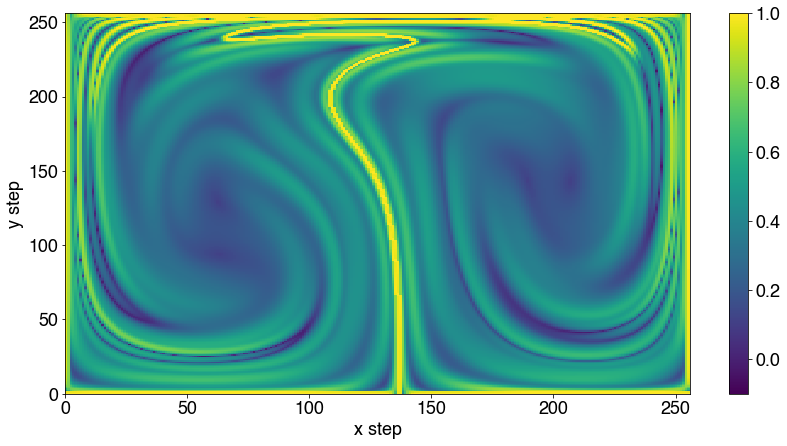

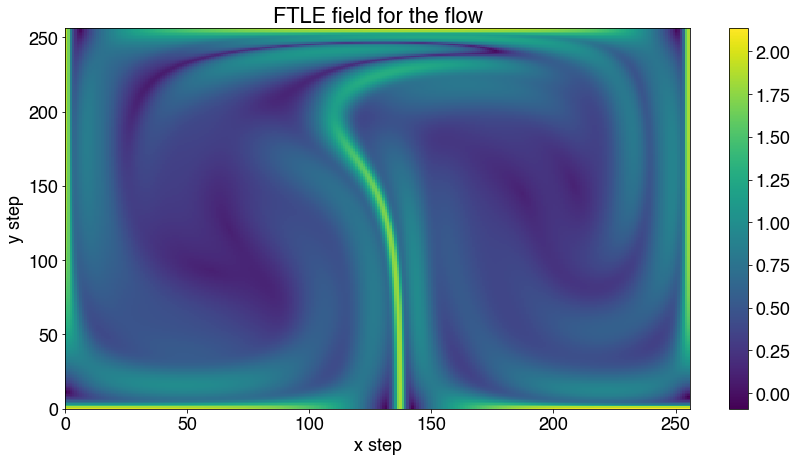

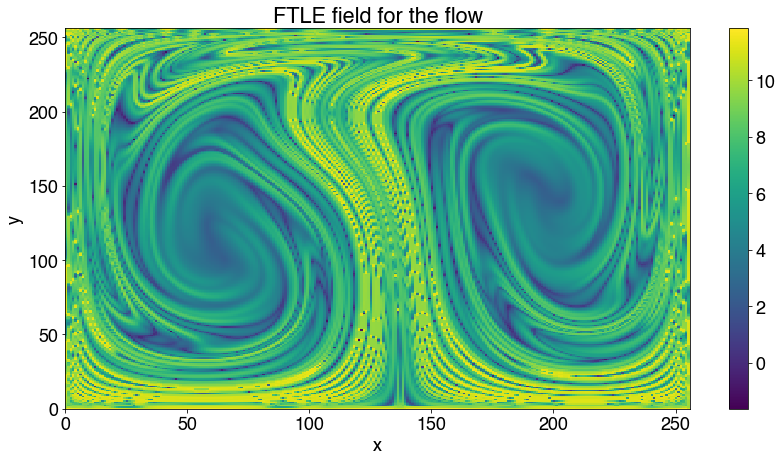

In [9]:
# test FTLE 
FTLE_field = FTLEcalc2d(x_pos[0], y_pos[0], x_pos[100], y_pos[100], dt*100)

plt.figure(figsize = (14,7))
plt.pcolor(FTLE_field)
plt.colorbar()
plt.clim((-0.1,1))
plt.xlabel('x step')
plt.ylabel('y step')
#plt.title('FTLE field for the flow')
plt.show()

FTLE_field = FTLEcalc2d(x_pos[0], y_pos[0], x_pos[50], y_pos[50], dt*50)

plt.figure(figsize = (14,7))
plt.pcolor(FTLE_field)
plt.colorbar()
#plt.clim((-0.1,0.2))
plt.xlabel('x step')
plt.ylabel('y step')
plt.title('FTLE field for the flow')
plt.show()

FTLE_field = FTLEcalc2d(x_pos[0], y_pos[0], x_pos[-1], y_pos[-1], dt*final_time)

plt.figure(figsize = (14,7))
plt.pcolor(FTLE_field)
plt.colorbar()
#plt.clim((-0.1,0.2))
plt.xlabel('x')
plt.ylabel('y')
plt.title('FTLE field for the flow')
plt.show()

## Constructing Q matrix

In [14]:
# define variables
r=2
epsilon=0.004

# number of data points at each time step
m = x_pos[0].flatten().shape[0]

# init empty matrix
Q = np.zeros((m,m))

# distance cutoff
dist_range = np.sqrt(r*epsilon)

ident = eye(m)

start_time = time()

# loop through each time step
for i in range(len(x_pos)):
    
    start_loop = time()
    
    # retrieve data
    x, y = flatten(x_pos[i], y_pos[i])
        
    coords = column_stack((x,y))
        
    # get distance matrix
    dist_mat = cdist(coords, coords)
    
    # set distances over range to 0
    K = np.where(dist_mat <= dist_range, dist_mat, 0)
    
    # square and divide by epsilon
    K = exp(-(K**2)/epsilon)
    
    # set values of 1 to 0
    K = where(K == 1, 0, K)
    
    # set diagonal entries to 1
    K += ident
    
    # compute diffusion map matrix 
    q = 1 / np.sum(K, axis=1)
    
    p_epsilon = np.diag(q)@K
    d_epsilon = 1/np.sum(p_epsilon, axis=0)
    B = np.diag(d_epsilon) @ p_epsilon.T @ p_epsilon
    
    Q += B
    
    end_loop = time()
    
    print(f'Loop time: {end_loop - start_loop}')

# normalize
Q = Q/len(x_pos)

end_time = time()

print(f'The time taken is: {end_time-start_time}')

Loop time: 2.7461869716644287
Loop time: 2.751781940460205
Loop time: 2.9868268966674805
Loop time: 3.301995038986206
Loop time: 3.436317205429077
Loop time: 3.339895009994507
Loop time: 3.0917651653289795
Loop time: 3.214550018310547
Loop time: 3.24885892868042
Loop time: 3.518927812576294
Loop time: 3.627007007598877
Loop time: 3.4456429481506348
Loop time: 3.2505180835723877
Loop time: 3.832068920135498
Loop time: 3.709322929382324
Loop time: 3.5486948490142822
Loop time: 3.4549200534820557
Loop time: 3.3473150730133057
Loop time: 3.392904043197632
Loop time: 3.3308911323547363
Loop time: 3.4232120513916016
Loop time: 3.425506830215454
Loop time: 3.393876075744629
Loop time: 3.9364700317382812
Loop time: 3.5429420471191406
Loop time: 4.246275186538696
Loop time: 3.9611308574676514
Loop time: 3.647531032562256
Loop time: 3.672269105911255
Loop time: 3.328389883041382
Loop time: 3.2849979400634766
Loop time: 3.3841516971588135
Loop time: 3.287633180618286
Loop time: 3.3807811737060547

In [16]:
# compute 
L = 1/epsilon * (Q - np.eye(Q.shape[0]))

# compute eigenvalues
vals, vecs = np.linalg.eig(L)

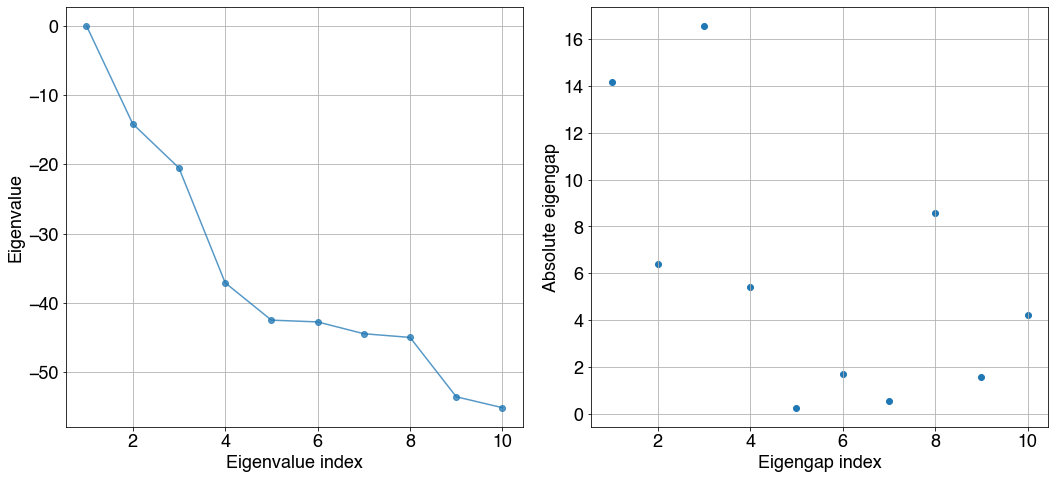

3

In [86]:
idx = np.arange(vals.shape[0])

# only use real part of eigenval
vals = np.real(vals)

plt.figure(figsize=(15,7))
plt.subplot(121)
plt.plot(np.arange(vals.shape[0])[:10] + 1, vals[:10], '-o',
         alpha=0.75)
plt.xlabel('Eigenvalue index')
plt.ylabel('Eigenvalue')
# plt.title('The first 10 eigenvalues of the matrix $L_{\epsilon}$')
plt.grid()

plt.subplot(122)
plt.scatter((np.arange(vals.shape[0]) +1)[:10], np.diff(abs(vals))[:10])
plt.grid()
plt.xlabel('Eigengap index')
plt.ylabel('Absolute eigengap')
plt.tight_layout()

plt.show()

# automatically detect no_clusters from eigengap
no_clust = np.where(abs(np.diff(np.real(vals))) == max(abs(np.diff(np.real(vals)))))[0][0] + 1
no_clust

Text(0, 0.5, 'Eigengap')

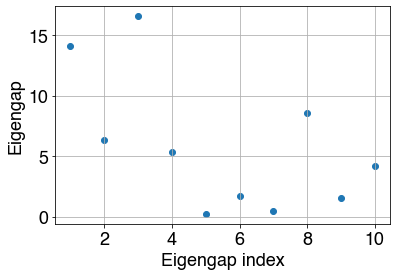

In [77]:
plt.scatter((np.arange(vals.shape[0]) +1)[:10], np.diff(abs(vals))[:10])
plt.grid()
plt.xlabel('Eigengap index')
plt.ylabel('Eigengap')

---
## Using Q as affinity matrix
This actually appears to work for 3/4 clusters but not for 2. I believe this is because the mehtod requires noise/non-coherent regions to be included as an additional cluster.

/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  return f(*args, **kwargs)


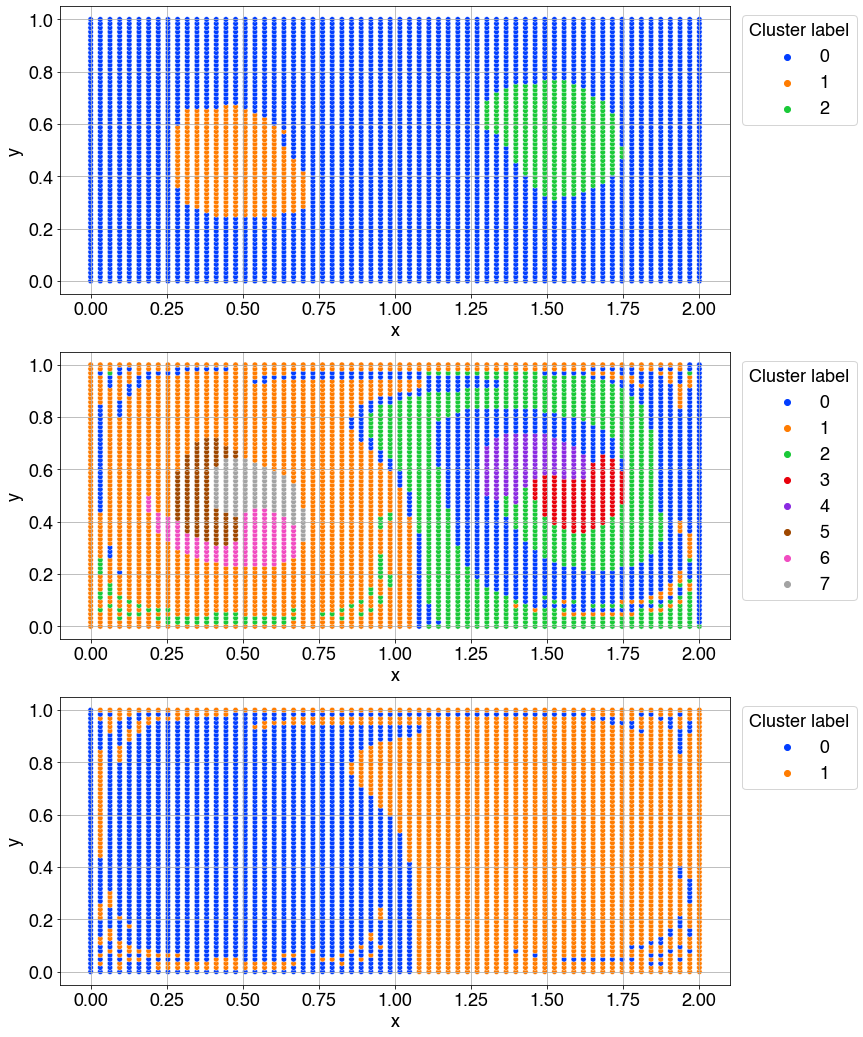

In [96]:
from sklearn.cluster import SpectralClustering, KMeans

# fit spectral clustering
sc = SpectralClustering(3, affinity='precomputed').fit(Q)

legend_lab = np.arange(3)+1
point_size=30

colour = 'bright'

# plot initial position with labels
#plt.subplots(1,2,1)
plt.figure(figsize=(12,18))
plt.subplot(3,1,1)
sns.scatterplot(x=x_pos[0].flatten(),
                y=y_pos[0].flatten(),
                hue=sc.labels_,
                palette = colour,
                s = point_size,
                legend='full')
# plt.title('Clustering Result')
plt.legend(title='Cluster label', bbox_to_anchor=(1.005,1))
plt.xlabel('x')
plt.ylabel('y')
plt.grid()

# fit spectral clustering
sc = SpectralClustering(8, affinity='precomputed').fit(Q)

# plot initial position with labels
#plt.subplots(1,2,1)

plt.subplot(3,1,2)
sns.scatterplot(x=x_pos[0].flatten(),
                y=y_pos[0].flatten(),
                hue=sc.labels_,
                palette = colour,
                s = point_size,
                legend='full')
# plt.title('Clustering Result')
plt.legend(title='Cluster label', bbox_to_anchor=(1.005,1))
plt.xlabel('x')
plt.ylabel('y')
plt.grid()

# fit spectral clustering
sc = SpectralClustering(2, affinity='precomputed').fit(Q)

# plot initial position with labels
#plt.figure(figsize=(12,6))
plt.subplot(3,1,3)

sns.scatterplot(x=x_pos[0].flatten(),
                y=y_pos[0].flatten(),
                hue=sc.labels_,
                palette = colour,
                s = point_size,
                legend='full')
# plt.title('Clustering Result')
plt.legend(title='Cluster label', bbox_to_anchor=(1.005,1))
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
#plt.tight_layout()
plt.show()

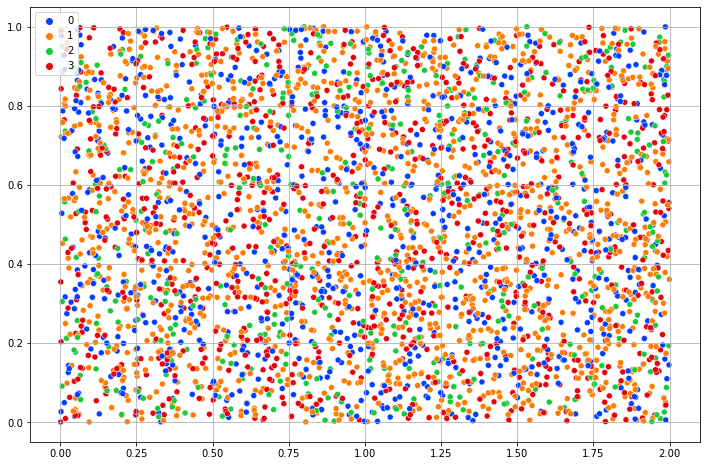

In [9]:
# # Run k means on normalized laplacian eigenvectors
# result = KMeans(4,
#                max_iter = 1000
#                ).fit(np.real(vecs))

# # plot initial position with labels
# plt.figure(figsize=(12,8))
# sns.scatterplot(x=x_pos[0],
#                 y=y_pos[0],
#                 hue=result.labels_,
#                 palette = 'bright')
# plt.grid()
# plt.show()

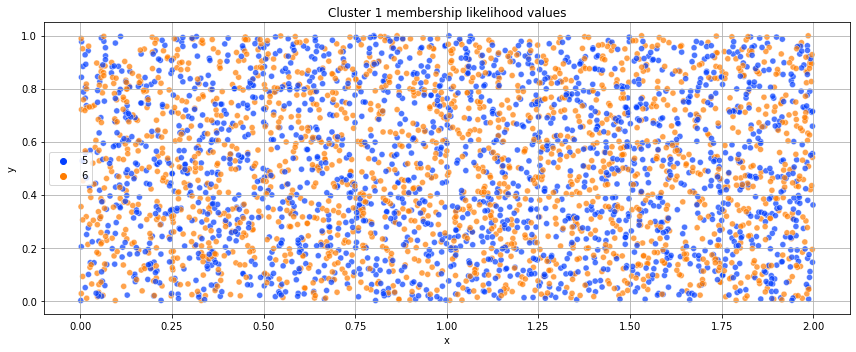

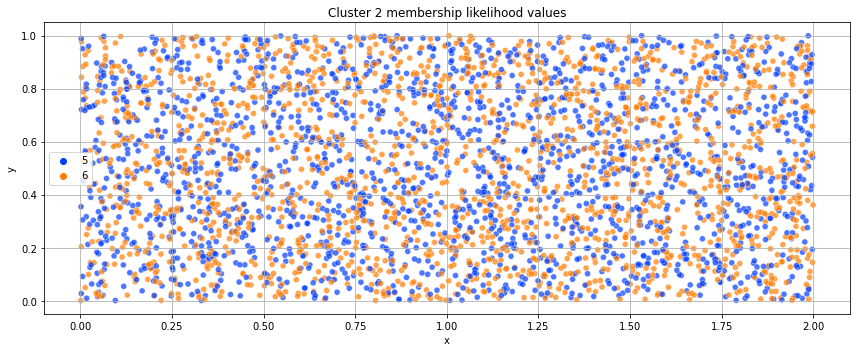

-------------------------------------------------------------------------------------------------



In [10]:
# no_clusters = 2

# # fuzzy c-means
# fuzzy_result = fuzz.cluster.cmeans(np.real(vecs).T,
#                           no_clusters,
#                           m=2,
#                           error=10**(-3),
#                           maxiter= 10**3)

# # final x and y positions - easier visualisation
# x_dat = x_pos[0]
# y_dat = y_pos[0]

# u = fuzzy_result[1].T

# plot_cluster_likelihoods(x_dat, y_dat, u)

In [11]:
# extract 'k+1' clusters
clust_centres = np.real(fuzzy_result[0].T[:3])
clust_centres

array([[-1.66666667e-02, -1.66666667e-02],
       [-7.02648736e-05, -7.02647926e-05],
       [-2.87420930e-04, -2.87421589e-04]])

In [12]:
# for i in range(len(x_pos)):
    
#     plt.figure(figsize=(14,10))
#     plt.scatter(x_pos[i], y_pos[i])
#     plt.show()